# 先把训练集70%、验证集15%、测试集15%的标注文件做好，原始音频切割成3s片段，分好样本集合后随机加噪声。

# 处理原始音频

In [2]:
from pathlib import Path
import os
import librosa
import numpy as np
import glob
import soundfile as sf
import noisereduce as nr
import scipy.signal as signal
from scipy.io import wavfile
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shutil
import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
data_root = Path(r"X:\数据集\DeepShip\data_original")
annotation_root = Path(r"X:\数据集\DeepShip\annotation_original")

meta_files = {
    "Cargo": annotation_root / "cargo-metafile.csv",
    "Passengership": annotation_root / "passengership-metafile.csv",
    "Tanker": annotation_root / "tanker-metafile.csv",
    "Tug": annotation_root / "tug-metafile.csv",
}

def parse_id(folder_name: str) -> int | None:
    parts = folder_name.rsplit("-", 1)
    if len(parts) != 2 or not parts[1].isdigit():
        return None
    return int(parts[1])

summary = {}

for cls, meta_path in meta_files.items():
    annotation = pd.read_csv(meta_path)
    expected_ids = set(annotation["ID"].astype(int))

    cls_dir = data_root / cls
    if not cls_dir.exists():
        summary[cls] = {"error": f"目录不存在: {cls_dir}"}
        continue

    folder_ids: dict[int, Path] = {}
    invalid_names: list[str] = []
    duplicate_names: list[str] = []

    for subdir in cls_dir.iterdir():
        if not subdir.is_dir():
            continue
        sid = parse_id(subdir.name)
        if sid is None:
            invalid_names.append(subdir.name)
            continue
        # 如果同一个 ID 出现多个文件夹，记录重复名称
        if sid in folder_ids:
            duplicate_names.append(subdir.name)
        else:
            folder_ids[sid] = subdir

    observed_ids = set(folder_ids)
    missing_ids = sorted(expected_ids - observed_ids)
    extra_ids = sorted(observed_ids - expected_ids)

    missing_audio = []
    renamed_audio = []

    for sid, folder in folder_ids.items():
        expected_wav = folder / f"{sid}.wav"
        if expected_wav.exists():
            # 名称已经对上
            continue

        # 这里没有标准命名，尝试重命名
        wav_files = list(folder.glob("*.wav"))

        if len(wav_files) == 1:
            src = wav_files[0]
            src.rename(expected_wav)
            renamed_audio.append(f"{src.name} -> {expected_wav.name}")
        elif len(wav_files) > 1:
            missing_audio.append(
                f"{folder}（发现多个 wav：{', '.join(f.name for f in wav_files)}）"
            )
        else:
            missing_audio.append(f"{expected_wav}（文件夹没有 wav）")

    summary[cls] = {
        "annotated_count": len(expected_ids),
        "folder_count": len(observed_ids),
        "missing_ids": missing_ids,
        "extra_ids": extra_ids,
        "invalid_folder_names": invalid_names,
        "duplicate_folder_names": duplicate_names,
        "missing_wav_files": missing_audio,
        "renamed_wav_files": renamed_audio if renamed_audio else "OK",
    }

for cls, info in summary.items():
    print(cls)
    for key, value in info.items():
        if isinstance(value, list):
            print(f"  {key}: {value if value else 'OK'}")
        else:
            print(f"  {key}: {value}")
    print("-" * 40)

In [ ]:
annotations = pd.read_csv(r"X:\数据集\DeepShip\data_preprocessing\annotation\DeepShip.csv")
data_root = Path(r"X:\数据集\DeepShip\data_preprocessing\data")

class_dirs = {
    0: "Cargo",
    1: "Passengership",
    2: "Tanker",
    3: "Tug",
}

for _, row in annotations.iterrows():
    cls_id = int(row["class_id"])
    sample_id = int(row["ID"])
    folder_name = row["folder_name"]

    if pd.isna(folder_name):
        print(f"ID:{sample_id}缺少folder_name，跳过ID:{sample_id}, class_id:{cls_id}")
        continue

    subdir = class_dirs.get(cls_id)
    if subdir is None:
        print(f"未知 class_id={cls_id}，跳过")
        continue

    src_dir = data_root / subdir / str(folder_name)
    if not src_dir.exists():
        print(f"目录不存在: {src_dir}")
        continue

    src_file = src_dir / f"{sample_id}.wav"
    dst_file = src_dir / f"{cls_id}_{sample_id}.wav"

    if dst_file.exists():
        print(f"目标名已存在，跳过: {dst_file}")
        continue

    src_file.rename(dst_file)

In [ ]:
# 原目录
root = Path(r"X:\数据集\DeepShip\data_preprocessing")
categories = ["Cargo", "Passengership", "Tanker", "Tug"]
# 目标目录：同级生成 data_new/Cargo
dest_root = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename")

# 需要的音频后缀，可按需扩展
audio_suffixes = {".wav"}

for category in categories:
    src_dir = root / "data" / category
    dst_dir = dest_root / category
    dst_dir.mkdir(parents=True, exist_ok=True)

    for audio in src_dir.rglob("*"):
        if audio.is_file() and audio.suffix.lower() in audio_suffixes:
            target = dst_dir / audio.name
            if target.exists():
                print(f"[跳过] {category}/{audio.name} 已存在，未覆盖。")
                continue
            shutil.copy2(audio, target)
            print(f"[复制] {audio.relative_to(root)} -> {target.relative_to(root)}")

# 3s分帧加窗，直接在原始音频上处理

In [3]:
wav_path = r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename\Cargo\0_1.wav"

waveform, sr = librosa.load(wav_path, sr=None)
print(f"Sample rate: {sr} Hz")
print(f"Waveform shape: {waveform.shape}")
print(f"Duration: {len(waveform) / sr:.2f} s")

Sample rate: 32000 Hz
Waveform shape: (14624000,)
Duration: 457.00 s


In [6]:
frame_duration = 3  # 帧时长为3秒
overlap_rate = 0.0  # 帧与帧之间的重叠率为0%

INPUT_ROOT = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename")
# OUTPUT_ROOT = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz")
OUTPUT_ROOT = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_RMS_pre_emphasis")

def apply_window(frame: np.ndarray) -> np.ndarray:
    window = np.hanning(len(frame)).astype(np.float32)
    return frame * window

def normalize_and_center(audio: np.ndarray) -> np.ndarray:
    max_amp = np.max(np.abs(audio))
    normalized = audio / max_amp if max_amp > 0 else audio
    return normalized - normalized.mean()

def apply_pre_emphasis(audio: np.ndarray, alpha: float = 0.97) -> np.ndarray:
    pre_emphasis = np.array([1.0, -alpha], dtype=np.float32)
    return signal.lfilter(pre_emphasis, 1, audio)

In [7]:
for category in ["Cargo", "Passengership", "Tanker", "Tug"]:
    in_dir = INPUT_ROOT / category
    out_dir = OUTPUT_ROOT / category
    out_dir.mkdir(parents=True, exist_ok=True)

    wav_paths = sorted(glob.glob(str(in_dir / "*.wav")))
    if not wav_paths:
        print(f"{category}: no wav files found, skip.")
        continue
    
    for wav_path in wav_paths:
        file_name = Path(wav_path).name
        file_stem = Path(wav_path).stem

        audio, sr = librosa.load(wav_path, sr=None)
        audio = audio.astype(np.float32, copy=False)

        print(f"Processing file: {file_name}, Sample Rate: {sr}, Total Samples: {len(audio)}")

        audio = normalize_and_center(audio)
        audio = apply_pre_emphasis(audio, alpha=0.97)

        frame_length = int(frame_duration * sr)
        hop_length = int(frame_length * (1.0 - overlap_rate))

        total_samples = len(audio)
        if total_samples < frame_length:
            pad_len = frame_length - total_samples
        else:
            remainder = (total_samples - frame_length) % hop_length
            pad_len = 0 if remainder == 0 else hop_length - remainder

        audio_padded = (
            np.pad(audio, (0, pad_len), mode="constant") if pad_len > 0 else audio
        )

        frames = librosa.util.frame(
            audio_padded, frame_length=frame_length, hop_length=hop_length
        )

        frames_windowed = np.apply_along_axis(apply_window, 0, frames)

        for i, frame_windowed in enumerate(frames_windowed.T, start=1):
            out_path = out_dir / f"{file_stem}_{i}.wav"
            wavfile.write(out_path, sr, frame_windowed.astype(np.float32))
print("All files processed.")

Processing file: 0_1.wav, Sample Rate: 32000, Total Samples: 14624000
Processing file: 0_10.wav, Sample Rate: 32000, Total Samples: 9312000
Processing file: 0_100.wav, Sample Rate: 32000, Total Samples: 11200000
Processing file: 0_101.wav, Sample Rate: 32000, Total Samples: 10208000
Processing file: 0_102.wav, Sample Rate: 32000, Total Samples: 14144000
Processing file: 0_103.wav, Sample Rate: 32000, Total Samples: 6368000
Processing file: 0_104.wav, Sample Rate: 32000, Total Samples: 7968000
Processing file: 0_105.wav, Sample Rate: 32000, Total Samples: 14848000
Processing file: 0_106.wav, Sample Rate: 32000, Total Samples: 10752000
Processing file: 0_107.wav, Sample Rate: 32000, Total Samples: 7520000
Processing file: 0_108.wav, Sample Rate: 32000, Total Samples: 11520000
Processing file: 0_109.wav, Sample Rate: 32000, Total Samples: 21344000
Processing file: 0_11.wav, Sample Rate: 32000, Total Samples: 14112000
Processing file: 0_110.wav, Sample Rate: 32000, Total Samples: 6464000
P

# 处理标注文件，70/15/15 划分

In [6]:
ANNOT_PATH = Path(r"X:\数据集\DeepShip\data_preprocessing\annotation\DeepShip.csv")
SEG_ROOT   = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_RMS")

CLASS_ID_TO_NAME = {
    0: "Cargo",
    1: "Passengership",
    2: "Tanker",
    3: "Tug",
}

annotation = pd.read_csv(ANNOT_PATH)
extended_rows = []

for _, row in annotation.iterrows():
    cls_id = int(row["class_id"])
    cls_name = CLASS_ID_TO_NAME[cls_id]
    base_id = int(row["ID"])

    pattern = f"{cls_id}_{base_id}_*.wav"
    feature_paths = sorted((SEG_ROOT / cls_name).glob(pattern))
    if not feature_paths:
        print(f"缺少特征: {cls_name} ID {base_id}")
        continue

    for feat_path in feature_paths:
        seg_idx = int(feat_path.stem.split("_")[-1])
        entry = row.to_dict()
        entry["segment_id"] = f"{cls_id}_{base_id}_{seg_idx}"
        extended_rows.append(entry)

extended_df = pd.DataFrame(extended_rows)
extended_columns = [
    "ID", "class ID", "Recording ID", "Ship Name",
    "Date & Time", "Duration(sec)", "Distances(m)",
    "class_id", "folder_name",
    "segment_id", "prompt_en",
]

extended_df = extended_df.reindex(columns=extended_columns)
out_path =  Path(r"X:\数据集\DeepShip\data_preprocessing\annotation\DeepShip_segments_3s_0%_16kHz_RMS_SNR.csv")
extended_df.to_csv(out_path, index=False)
print(f"写出 {len(extended_df)} 条记录 -> {out_path}")

缺少特征: Cargo ID 23
写出 56864 条记录 -> X:\数据集\DeepShip\data_preprocessing\annotation\DeepShip_segments_3s_0%_16kHz_RMS_SNR.csv


In [7]:
ANNOT_PATH = Path(r"X:\数据集\DeepShip\data_preprocessing\annotation\DeepShip_segments_3s_0%_16kHz_RMS_SNR.csv")
OUTPUT_PATH = Path(r"X:\数据集\DeepShip\data_preprocessing\annotation\DeepShip_segments_3s_0%_16kHz_RMS_SNR_split.csv")

SPLIT_SEED = 42
VAL_FRACTION = 0.15 / 0.85

segmented_df = pd.read_csv(ANNOT_PATH)

# 先分出 15% 的测试集
remain_df, test_df = train_test_split(
    segmented_df,
    test_size=0.15,
    random_state=SPLIT_SEED,
    stratify=segmented_df["class_id"],
)

# 再把剩余 85% 按比例拆成训练/验证（≈70% / 15%）
train_df, val_df = train_test_split(
    remain_df,
    test_size=VAL_FRACTION,
    random_state=SPLIT_SEED,
    stratify=remain_df["class_id"],
)

split_map = {"train": 0, "val": 1, "test": 2}
def add_split_cols(df, split_name):
    return df.assign(split=split_name, split_id=split_map[split_name])

train_df = add_split_cols(train_df, "train")
val_df   = add_split_cols(val_df, "val")
test_df  = add_split_cols(test_df, "test")

split_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
split_df.to_csv(OUTPUT_PATH, index=False)

print(
    f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}; saved to {OUTPUT_PATH}"
)

Train: 39804, Val: 8530, Test: 8530; saved to X:\数据集\DeepShip\data_preprocessing\annotation\DeepShip_segments_3s_0%_16kHz_RMS_SNR_split.csv


# 把训练集、验证集、测试集处理出来用三个文件夹，然后三个文件夹放在一个大文件夹下

In [8]:
ANNOTATION_CSV = Path(r"X:\数据集\DeepShip\data_preprocessing\annotation\DeepShip_segments_3s_0%_16kHz_RMS_SNR_split.csv")
# SEGMENT_ROOT = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz")
# OUTPUT_ROOT = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test")
# SEGMENT_ROOT = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_RMS")
# OUTPUT_ROOT = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS")
SEGMENT_ROOT = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_RMS_pre_emphasis")
OUTPUT_ROOT = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis")
SPLIT_DIRS = {
    "train": OUTPUT_ROOT / "train",
    "val": OUTPUT_ROOT / "val",
    "test": OUTPUT_ROOT / "test",
}

df = pd.read_csv(ANNOTATION_CSV)

for path in SPLIT_DIRS.values():
    path.mkdir(parents=True, exist_ok=True)

CLASS_ID_TO_NAME = {0: "Cargo", 1: "Passengership", 2: "Tanker", 3: "Tug"}

for _, row in tqdm(df.iterrows(), total=len(df)):
    split_name = row["split"]
    fname = str(row.get("segmented_filename", row["segment_id"]))
    if not fname.endswith(".wav"):
        fname += ".wav"

    cls_dir = CLASS_ID_TO_NAME[int(row["class_id"])]
    src = SEGMENT_ROOT / cls_dir / fname
    dst = SPLIT_DIRS[split_name] / fname

    if not src.exists():
        print(f"[WARN] Missing file: {src}")
        continue

    shutil.copy2(src, dst)

print("Done! Files are in", OUTPUT_ROOT)

100%|██████████| 56864/56864 [06:54<00:00, 137.21it/s]

Done! Files are in X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis


# 检查标注文件与样本是否一一对应，分别存放在三个子集中

In [9]:

annotation = Path(r"X:\数据集\DeepShip\data_preprocessing\annotation\DeepShip_segments_3s_0%_16kHz_RMS_SNR_split.csv")
# root = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test")
root = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis")

df = pd.read_csv(annotation)
def to_wav(row):
    name = str(row.get("segmented_filename", row.get("segment_id")))
    return name if name.lower().endswith(".wav") else f"{name}.wav"
df["wav_name"] = df.apply(to_wav, axis=1)

for split in ["train", "val", "test"]:
    expected = set(df.loc[df["split"] == split, "wav_name"])
    actual = {p.name for p in (root / split).glob("*.wav")}
    print(split, "missing_on_disk=", len(expected - actual), "not_listed_in_csv=", len(actual - expected))

train missing_on_disk= 0 not_listed_in_csv= 0
val missing_on_disk= 0 not_listed_in_csv= 0
test missing_on_disk= 0 not_listed_in_csv= 0


In [10]:

# 1. 配置路径
ANNOT_PATH = Path(r"X:\数据集\DeepShip\data_preprocessing\annotation\DeepShip_segments_3s_0%_16kHz_RMS_SNR_split.csv")
DATA_ROOT  = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis")

# 2. 读标注
df = pd.read_csv(ANNOT_PATH)

# 3. 统一生成 wav 文件名
def to_wav_name(row):
    # 优先用 segmented_filename，没有就退回 segment_id
    name = row.get("segmented_filename", None)
    if pd.isna(name):
        name = row.get("segment_id")
    name = str(name)
    if not name.lower().endswith(".wav"):
        name = name + ".wav"
    return name

# 4. 从标注里收集“期望文件集合”
expected = defaultdict(set)  # split -> set of filenames

for _, row in df.iterrows():
    split = str(row["split"])   # "train" / "val" / "test"
    fname = to_wav_name(row)
    expected[split].add(fname)

# 5. 遍历文件夹里的实际文件（递归扫 *.wav）
for split in ["train", "val", "test"]:
    split_dir = DATA_ROOT / split
    if not split_dir.exists():
        print(f"[WARN] 目录不存在：{split_dir}")
        continue

    # rglob 可以递归到子目录（比如 val/SNR_0dB/... 这种结构）
    actual_files = {p.name for p in split_dir.rglob("*.wav")}

    expected_files = expected.get(split, set())

    missing = expected_files - actual_files
    extra   = actual_files - expected_files

    print(f"\n=== Split: {split} ===")
    print(f"标注中样本数: {len(expected_files)}")
    print(f"文件夹中样本数: {len(actual_files)}")

    if not missing and not extra:
        print("✔ 标注与文件夹完全一致。")
    else:
        if missing:
            print(f"✘ 缺失文件数: {len(missing)}，示例前 10 个：")
            for f in list(sorted(missing))[:10]:
                print("   [MISSING]", f)
        if extra:
            print(f"✘ 多余文件数: {len(extra)}，示例前 10 个：")
            for f in list(sorted(extra))[:10]:
                print("   [EXTRA]", f)


=== Split: train ===
标注中样本数: 39804
文件夹中样本数: 39804
✔ 标注与文件夹完全一致。

=== Split: val ===
标注中样本数: 8530
文件夹中样本数: 8530
✔ 标注与文件夹完全一致。

=== Split: test ===
标注中样本数: 8530
文件夹中样本数: 8530
✔ 标注与文件夹完全一致。


# 训练集随机加噪，验证集、测试集固定噪声分贝数

In [3]:
SOURCE_ROOT = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis")
ANNOTATION_CSV = Path(r"X:\数据集\DeepShip\data_preprocessing\annotation\DeepShip_segments_3s_0%_16kHz_RMS_SNR_split.csv")
# DEST_ROOT = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis_float_noisy_dataset")
DEST_ROOT = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis_noisy_dataset")

TRAIN_RANGE = (-12, 6)
EVAL_SNRS = np.array([-12, -9, -6, -3, 0, 3, 6], dtype=np.int32)
# EVAL_SNRS = np.array([6], dtype=np.int32)

DEST_ROOT.mkdir(parents=True, exist_ok=True)
df_split = pd.read_csv(ANNOTATION_CSV)

def to_wav_name(row):
    name = str(row.get("segmented_filename", row["segment_id"]))
    return f"{name}.wav" if not name.lower().endswith(".wav") else name

def add_noise_with_snr(signal, target_snr_db, rng):
    signal_power = np.mean(signal ** 2) + 1e-12
    snr_linear = 10 ** (target_snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise = rng.normal(0.0, np.sqrt(noise_power), size=signal.shape)
    return signal + noise

def load_waveform(split_name, file_name):
    wav_path = SOURCE_ROOT / split_name / file_name
    audio, sr = sf.read(wav_path)
    return audio.astype(np.float32), sr

train_rng = np.random.default_rng(42)

for _, row in tqdm(df_split.iterrows(), total=len(df_split)):
    split = row["split"]
    fname = to_wav_name(row)
    audio, sr = load_waveform(split, fname)

    if split == "train":
        snr = train_rng.integers(TRAIN_RANGE[0], TRAIN_RANGE[1] + 1)
        # snr = float(train_rng.uniform(TRAIN_RANGE[0], TRAIN_RANGE[1] + 1e-6))
        # snr = min(snr, TRAIN_RANGE[1]) 
        seed = train_rng.integers(0, 2**32 - 1)
        noisy = add_noise_with_snr(audio, snr, np.random.default_rng(seed))
        out_dir = DEST_ROOT / "train"
        out_dir.mkdir(parents=True, exist_ok=True)
        sf.write(out_dir / fname, noisy, sr, subtype="FLOAT")

    else:  # val/test
        for snr in EVAL_SNRS:
            seed_input = f"{fname}-{snr}"
            seed = np.uint32(abs(hash(seed_input)) & 0xFFFFFFFF)
            noisy = add_noise_with_snr(audio, snr, np.random.default_rng(seed))
            snr_dir = DEST_ROOT / split / f"SNR_{snr:+d}dB"
            snr_dir.mkdir(parents=True, exist_ok=True)
            sf.write(snr_dir / fname, noisy, sr, subtype="FLOAT")

print("Done! Noisy dataset saved under", DEST_ROOT)

100%|██████████| 56864/56864 [31:38<00:00, 29.95it/s]

Done! Noisy dataset saved under X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis_noisy_dataset


# 测试噪声添加是否正确

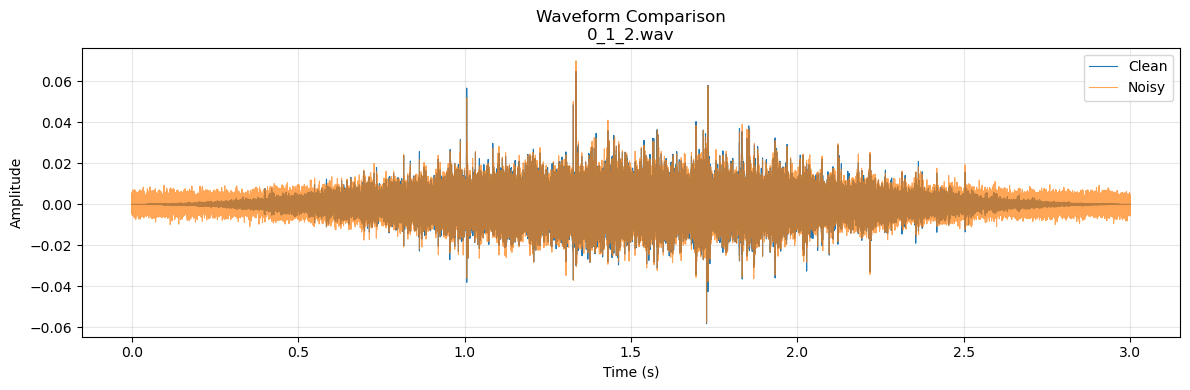

In [23]:
def plot_clean_vs_noisy(clean_path: Path | str, noisy_path: Path | str):
    clean, sr_clean = sf.read(clean_path, dtype="float32")
    noisy, sr_noisy = sf.read(noisy_path, dtype="float32")
    if sr_clean != sr_noisy:
        raise ValueError(f"采样率不一致: clean={sr_clean}, noisy={sr_noisy}")
    t = np.arange(len(clean)) / sr_clean

    plt.figure(figsize=(12, 4))
    plt.plot(t, clean, label="Clean", linewidth=0.8)
    plt.plot(t, noisy, label="Noisy", linewidth=0.8, alpha=0.7)
    plt.title(f"Waveform Comparison\n{Path(clean_path).name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_clean_vs_noisy(
    Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis\val\0_1_2.wav"),
    Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis_float_noisy_dataset\val\SNR_+6dB\0_1_2.wav")
)

In [ ]:
def measure_snr_db(clean_path, noisy_path):
    clean, sr_clean = sf.read(clean_path, dtype="float32")
    noisy, sr_noisy = sf.read(noisy_path, dtype="float32")
    if sr_clean != sr_noisy:
        raise ValueError(f"Sample rate mismatch: {sr_clean} vs {sr_noisy}")

    # 截成相同长度，避免后缀补零差异
    min_len = min(len(clean), len(noisy))
    clean = clean[:min_len]
    noisy = noisy[:min_len]

    noise = noisy - clean
    signal_power = np.mean(clean ** 2) + 1e-12
    noise_power = np.mean(noise ** 2) + 1e-12
    snr_db = 10.0 * np.log10(signal_power / noise_power)
    return snr_db

clean_path = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis\val\0_1_2.wav")
noisy_path = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis_float_noisy_dataset\val\SNR_+6dB\0_1_2.wav")

print(f"SNR = {measure_snr_db(clean_path, noisy_path):.2f} dB")

SNR = 6.00 dB


In [ ]:
def peak_amplitude(path):
    audio, _ = sf.read(path, dtype="float32")
    return float(np.max(np.abs(audio)))

def compare_peaks(clean_path, noisy_path):
    clean_peak = peak_amplitude(clean_path)
    noisy_peak = peak_amplitude(noisy_path)
    print(f"Clean peak: {clean_peak:.6f}")
    print(f"Noisy peak: {noisy_peak:.6f}")

clean = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis\val\0_1_2.wav")
noisy = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis_float_noisy_dataset\val\SNR_+6dB\0_1_2.wav")

compare_peaks(clean, noisy)

Clean peak: 0.064839
Noisy peak: 0.069932


In [ ]:
def inspect_powers(clean_path, noisy_path, target_db=6.0):
    clean, sr = sf.read(clean_path, dtype="float32")
    noisy, sr2 = sf.read(noisy_path, dtype="float32")
    if sr != sr2:
        raise ValueError(f"Sample rate mismatch: {sr} vs {sr2}")

    min_len = min(len(clean), len(noisy))
    clean = clean[:min_len]
    noisy = noisy[:min_len]

    noise = noisy - clean
    signal_power = float(np.mean(clean ** 2))
    noise_power = float(np.mean(noise ** 2))
    ratio = signal_power / noise_power
    expected = 10 ** (target_db / 10.0)

    print(f"signal_power = {signal_power:.8e}")
    print(f"noise_power  = {noise_power:.8e}")
    print(f"ratio        = {ratio:.5f}")
    print(f"10^(SNR/10)  = {expected:.5f}")

    clean = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis\val\0_1_2.wav")
    noisy = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis_float_noisy_dataset\val\SNR_+6dB\0_1_2.wav")
inspect_powers(clean, noisy, target_db=6.0)

signal_power = 2.53826256e-05
noise_power  = 6.37908897e-06
ratio        = 3.97904
10^(SNR/10)  = 3.98107


# 提取特征

In [4]:
INPUT_ROOT = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis_noisy_dataset")
OUTPUT_ROOT = Path(r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test_RMS_pre_emphasis_noisy_dataset_features")

SPLITS = ["train", "val", "test"]  

SAMPLE_RATE = 16000
N_MEL = 128
N_MFCC = 40 
N_FFT = 2048
HOP_LENGTH = 512
# N_FFT = 512
# HOP_LENGTH = 256

In [6]:
def save_array(target_path: Path, array):
    target_path.parent.mkdir(parents=True, exist_ok=True)
    np.save(target_path, array)

for split in SPLITS:
    split_in = INPUT_ROOT / split
    split_out = OUTPUT_ROOT / split

    wav_paths = sorted(split_in.rglob("*.wav"))
    if not wav_paths:
        print(f"[{split}] no wav files, skip")
        continue

    for wav_path in tqdm(wav_paths, desc=f"{split} wav", unit="file"):
        y, sr = librosa.load(wav_path, sr=SAMPLE_RATE)

        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MEL, n_fft=N_FFT, hop_length=HOP_LENGTH)
        # mel_db = librosa.power_to_db(mel, ref=np.max)
        # mel_db = librosa.power_to_db(mel, ref=1.0)
        mel_db = librosa.power_to_db(mel)

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)

        # waveform = y.astype(np.float32)

        rel = wav_path.relative_to(split_in).with_suffix(".npy")
        save_array(split_out / "mel" / rel, mel_db)
        save_array(split_out / "mfcc" / rel, mfcc)
        # save_array(split_out / "waveform" / rel, waveform)

        # print(f"[{split}] {wav_path} -> mel/mfcc/waveform saved")
        # print(f"[{split}] {wav_path} -> mel/mfcc saved")

test wav: 100%|██████████| 59710/59710 [15:32<00:00, 64.02file/s]
